# $^{222}\text{Rn}$-$\alpha$ in $\text{Xe}$

¿Quién me le habló feo al proceso de reconstrucción?

In [1]:
import sys
sys.path.append('/data_extra2/ccortesp/NEXT-100/Xe_cmmssnng/')

import crudo
import fit_functions as ff
from   iminuit import Minuit
from   iminuit.cost import LeastSquares
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotting_tools as pt
import tables as tb
from   scipy import integrate
from   scipy.optimize import curve_fit
from   scipy.stats    import linregress

%matplotlib inline
%load_ext autoreload
%autoreload 2

/data_extra/software/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Runs Information

In [62]:

# Define the runs to be analyzed
runs_info = [
                # # Drift field scan: Oct 2024
                # {"run_number": 14440, "cath_HV": 18e3, "EL_HV": 6e3, "duration": 42952},
                # {"run_number": 14456, "cath_HV": 19e3, "EL_HV": 6e3, "duration": 56420},
                # {"run_number": 14468, "cath_HV": 20e3, "EL_HV": 6e3, "duration": 55696},
                # {"run_number": 14484, "cath_HV": 21e3, "EL_HV": 6e3, "duration": 48240},
                # {"run_number": 14489, "cath_HV": 22e3, "EL_HV": 6e3, "duration": 42314},
                # {"run_number": 14498, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 43161},
                # {"run_number": 14519, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 43274},
                # {"run_number": 14522, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 42801},
                # # Gas recirculation: Nov 2024
                # {"run_number": 14581, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 76086},
                # {"run_number": 14582, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 79541},
                # {"run_number": 14588, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 55856},
                # # EL voltage scan: Dic 2024
                # {"run_number": 14601, "cath_HV": 23e3, "EL_HV": 7e3, "duration": 77537},
                # {"run_number": 14608, "cath_HV": 23e3, "EL_HV": 8e3, "duration": 86414},
                # {"run_number": 14704, "cath_HV": 23e3, "EL_HV": 9e3, "duration": 52765},
                # # EL voltage scan: Jan 2025
                # {"run_number": 14714, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 64527},
                # {"run_number": 14720, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 48518},
                # {"run_number": 14733, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 53881},
                # {"run_number": 14735, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 84987},
                # {"run_number": 14737, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 72705},
                # {"run_number": 14739, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 87138},
                # {"run_number": 14741, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 87755},
                # {"run_number": 14743, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 82332},
    
                # ----- A L P H A   R U N S ----- #
    
                # # Jan 2025
                # {"run_number": 14714, "duration": 64527, "OK": -1     , "LOST": -1     , "real_rate": -1    },
                # {"run_number": 14715, "duration": 84365, "OK": 2469062, "LOST": 2239303, "real_rate": 55.809},  # NO processed
                # {"run_number": 14716, "duration": 17036, "OK": 495769 , "LOST": 451306 , "real_rate": 55.592},
                # {"run_number": 14720, "duration": 48518, "OK": -1     , "LOST": -1     , "real_rate": -1    },
                # {"run_number": 14733, "duration": 53881, "OK": 1587637, "LOST": 1429629, "real_rate": 55.998},
                # {"run_number": 14735, "duration": 84987, "OK": 2508569, "LOST": 2267982, "real_rate": 56.203},
                # {"run_number": 14737, "duration": 72705, "OK": 2153786, "LOST": 1960347, "real_rate": 56.586},
                {"run_number": 14739, "duration": 87138, "OK": 2576630, "LOST": 2334343, "real_rate": 56.358},
                # {"run_number": 14741, "duration": 87755, "OK": 2592615, "LOST": 2349583, "real_rate": 56.318},
                # {"run_number": 14743, "duration": 82332, "OK": 2437984, "LOST": 2220643, "real_rate": 56.583},
                # {"run_number": 14745, "duration": 60990, "OK": 1803415, "LOST": 1636317, "real_rate": 56.398},
                # # --- NO Cold Getter: Jan 27 --- #
                # {"run_number": 14753, "duration": 86308, "OK": 2188547, "LOST": 1532351, "real_rate": 43.111},
                # {"run_number": 14765, "duration": 55978, "OK": 1259832, "LOST": 735202 , "real_rate": 35.639},
                # {"run_number": 14776, "duration": 47397, "OK": 957081 , "LOST": 481810 , "real_rate": 30.358},  # Data removed
                # {"run_number": 14780, "duration": 88503, "OK": 1600797, "LOST": 682246 , "real_rate": 25.796},
                # # Feb 2025
                # {"run_number": 14782, "duration": 85654, "OK": 1382153, "LOST": 506234 , "real_rate": 22.046},
                # {"run_number": 14784, "duration": 57290, "OK": 842541 , "LOST": 273581 , "real_rate": 19.481},
                # {"run_number": 14789, "duration": 74148, "OK": 976360 , "LOST": 277504 , "real_rate": 16.910},
                # # --- Zero Suppression --- #
                # {"run_number": 14803, "duration": 71721, "OK": 933727 , "LOST": 104677 , "real_rate": 14.478},
                # {"run_number": 14804, "duration": 65116, "OK": 680552 , "LOST": 156995 , "real_rate": 12.862},
                # # --- NO Zero Suppression --- #
                # {"run_number": 14811, "duration": -1   , "OK": -1     , "LOST": -1     , "real_rate": -1    },
                # {"run_number": 14814, "duration": 6344 , "OK": 55679  , "LOST": 10155  , "real_rate": 10.377},
                # {"run_number": 14815, "duration": 86232, "OK": 717786 , "LOST": 121527 , "real_rate": 9.733 },
                # {"run_number": 14816, "duration": 86580, "OK": 659265 , "LOST": 101374 , "real_rate": 8.785 },
                # {"run_number": 14817, "duration": 49662, "OK": 352203 , "LOST": 50474  , "real_rate": 8.108 },  
                # {"run_number": 14828, "duration": 53609, "OK": 300827 , "LOST": 100405 , "real_rate": 7.484 },
                # {"run_number": 14829, "duration": 73042, "OK": 387003 , "LOST": 121249 , "real_rate": 6.958 },
                # {"run_number": 14834, "duration": 5779 , "OK": 32864  , "LOST": 3887   , "real_rate": 6.359 },
                # {"run_number": 14835, "duration": 11713, "OK": 66515  , "LOST": 7358   , "real_rate": 6.306 },
                # {"run_number": 14837, "duration": 55751, "OK": 294175 , "LOST": 31034  , "real_rate": 5.833 },
                # {"run_number": 14838, "duration": 87854, "OK": 431766 , "LOST": 42219  , "real_rate": 5.395 },
                # {"run_number": 14839, "duration": 84881, "OK": 401004 , "LOST": 37747  , "real_rate": 5.169 },
                # {"run_number": 14840, "duration": 55363, "OK": 260266 , "LOST": 22528  , "real_rate": 5.108 },  # Elog malfunction: estimated values              
            ]

## Irene
Load the filter dataframes, first.

In [63]:
# Initialize dictionary to store Irene filter data
irene_filts = {"s12_indices": {}, "empty_pmap": {}}

# Iterate over each filter type and load data for all runs
for i, filtro in enumerate(irene_filts):
    
    filt_path = f'/Filters/{filtro}'  # Define filter path
    # Load data for each run and store it in the corresponding filter dictionary
    irene_filts[filtro] = {run["run_number"]: crudo.load_run_data(run, city="irene", output=filt_path)[run["run_number"]] for run in runs_info}


/Filters/s12_indices: Run 14739 successfully stored with data shape: (31500, 2)
/Filters/empty_pmap: Run 14739 successfully stored with data shape: (31500, 2)


In [64]:
for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]

    for j, filtro in enumerate(irene_filts):

        # H5 table
        data = irene_filts[filtro][run_id]

        # Filter efficiency
        OK = data.passed.value_counts()[1]
        total = data.passed.size
        eff = OK / total
        print(f'{filtro} efficiency = {eff:.4} ({OK} / {total})')

s12_indices efficiency = 1.0 (31500 / 31500)
empty_pmap efficiency = 1.0 (31500 / 31500)


## Sohpronia
Load the filter dataframes

In [65]:
# Initialize dictionary to store Sophronia filter data
soph_filts = {"s12_selector": {}, "valid_hit": {}}

# Iterate over each filter type and load data for all runs
for i, filtro in enumerate(soph_filts):
    
    filt_path = f'/Filters/{filtro}'  # Define filter path
    # Load data for each run and store it in the corresponding filter dictionary
    soph_filts[filtro] = {run["run_number"]: crudo.load_run_data(run, city="sophronia", output=filt_path)[run["run_number"]] for run in runs_info}


/Filters/s12_selector: Run 14739 successfully stored with data shape: (2576630, 2)
/Filters/valid_hit: Run 14739 successfully stored with data shape: (339737, 2)


In [66]:
for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    print(f'Run {run_id}:')

    for j, filtro in enumerate(soph_filts):

        # H5 table
        data = soph_filts[filtro][run_id]

        # Filter efficiency
        OK = data.passed.value_counts()[1]
        total = data.passed.size
        eff = OK / total
        print(f'  {filtro} efficiency = {eff:.4} ({OK} / {total})')

Run 14739:
  s12_selector efficiency = 0.1319 (339737 / 2576630)
  valid_hit efficiency = 0.9492 (322462 / 339737)


## Outdated

In [11]:
# Sophronia outputs
s12_sel = "/Filters/s12_selector"
print(s12_sel)
runs_data_s12 = {run["run_number"]: crudo.load_run_data(run, sophronia_output=s12_sel)[run["run_number"]] for run in runs_info}

valid_h = "/Filters/valid_hit"
print(valid_h)
runs_data_vh = {run["run_number"]: crudo.load_run_data(run, sophronia_output=valid_h)[run["run_number"]] for run in runs_info}

/Filters/s12_selector
Run 14739 successfully stored with data shape: (2576630, 2)
/Filters/valid_hit
Run 14739 successfully stored with data shape: (339737, 2)


### $S1$ - $S2$ Selector

['18/01', '19/01', '20/01', '21/01', '21/01', '22/01', '24/01', '25/01', '26/01', '27/01', '29/01', '30/01', '02/02', '03/02', '04/02', '05/02', '06/02', '07/02', '07/02', '08/02', '09/02', '10/02', '11/02', '12/02', '13/02', '13/02', '14/02', '15/02', '16/02', '17/02']


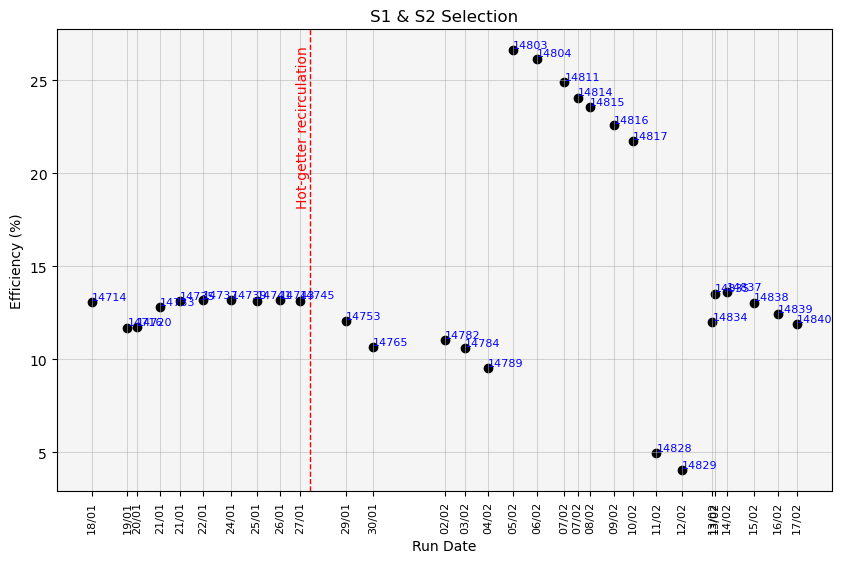

In [4]:
# Global
x_date = [1737179119.4976182, 1737307402.136773, 1737341437.4878135, 1737427275.580069, 1737500332.7076411, 
          1737583709.2390716, 1737687225.9733078, 1737779396.521381, 1737865625.6862938, 1737938887.2630675, 
          1738106359.7590237, 1738204666.647905, 1738468352.8594596, 1738541249.3330574, 1738625530.0505548, 
          1738716634.9481688, 1738803045.6190317, 1738903693.7949574, 1738952294.8542185, 1738997895.6787453, 
          1739084695.6470551, 1739153389.8059216, 1739239910.7918682, 1739334544.0412745, 1739444844.9121568, 
          1739454577.9925718, 1739496184.7882426, 1739595527.4786978, 1739682330.8394353, 1739752825.9474149]

plt.figure(figsize=(10, 6))

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    # Filter efficiency
    OK = runs_data_s12[run_id].passed.value_counts()[1]
    # print(f'Good Events = {OK}')
    S12_eff = (OK / runs_data_s12[run_id].passed.size) * 100
    # print(S12_eff)
    # x_date.append(run_id)
    
    # Plot
    plt.scatter(x_date[i], S12_eff, c='black', label=f'Run {run_id}')
    plt.text(x_date[i], S12_eff, str(run_id), fontsize=8, ha='left', va='bottom', color='blue')   # Run number near the point

# x_labels = ["27/01", "29/01", "30/01", "02/02", "03/02", "04/02", "05/02", "06/02", "07/02", "07/02", "08/02", "09/02", "10/02", "11/02", "12/02"]    
x_labels = [crudo.epoch_converter(t, h=False) for t in x_date]

print(x_labels)

# Ensure correct tick-label mapping
if len(x_date) != len(x_labels):
    print("⚠️ Warning: Mismatch between x_date and x_labels length!")

# Styling
plt.xlabel('Run Date')
plt.xticks(x_date, x_labels, rotation=90, ha='center', fontsize=8)
plt.ylabel('Efficiency (%)')
plt.title(r'S1 & S2 Selection')
plt.axvline(x=1737975600, c='red', ls='--', lw=1)
plt.text(1737975600, 22.5, 'Hot-getter recirculation', c='red', va='center',  ha='right',  rotation=90)

plt.gca().set_facecolor("whitesmoke")
plt.grid(True, linestyle='-', linewidth=0.75, alpha=0.5)
plt.savefig(f'images/soph_filt/s12_eff.png', bbox_inches='tight')
plt.show()

### Valid Hit

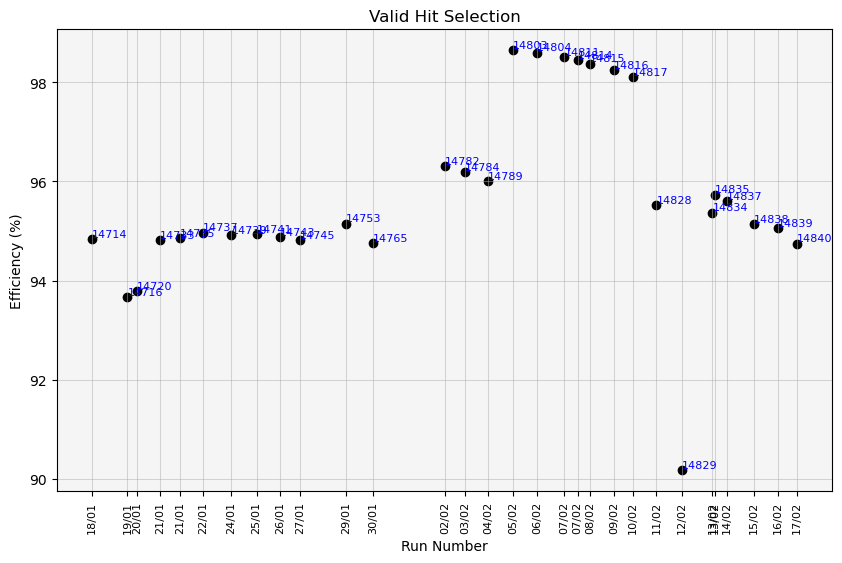

In [5]:
# Global
x_date = [1737179119.4976182, 1737307402.136773, 1737341437.4878135, 1737427275.580069, 1737500332.7076411, 
          1737583709.2390716, 1737687225.9733078, 1737779396.521381, 1737865625.6862938, 1737938887.2630675, 
          1738106359.7590237, 1738204666.647905, 1738468352.8594596, 1738541249.3330574, 1738625530.0505548, 
          1738716634.9481688, 1738803045.6190317, 1738903693.7949574, 1738952294.8542185, 1738997895.6787453, 
          1739084695.6470551, 1739153389.8059216, 1739239910.7918682, 1739334544.0412745, 1739444844.9121568, 
          1739454577.9925718, 1739496184.7882426, 1739595527.4786978, 1739682330.8394353, 1739752825.9474149]

plt.figure(figsize=(10, 6))

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    # Filter efficiency
    OK = runs_data_vh[run_id].passed.value_counts()[1]
    # print(f'Good Events = {OK}')
    vh_eff = (OK / runs_data_vh[run_id].passed.size) * 100
    # print(S12_eff)
    
    # Plot
    plt.scatter(x_date[i], vh_eff, c='black', label=f'Run {run_id}')
    plt.text(x_date[i], vh_eff, str(run_id), fontsize=8, ha='left', va='bottom', color='blue')   # Run number near the point

x_labels = [crudo.epoch_converter(t, h=False) for t in x_date]
    
# Styling
plt.xlabel('Run Number')
plt.xticks(x_date, x_labels, rotation=90, ha='center', fontsize=8)
plt.ylabel('Efficiency (%)')
plt.title(r'Valid Hit Selection')
# plt.axvline(x=1737975600, c='red', ls='--', lw=1)
# plt.text(1737975600, 3, 'Hot-getter recirculation', c='red', va='center',  ha='right',  rotation=90)

plt.gca().set_facecolor("whitesmoke")
plt.grid(True, linestyle='-', linewidth=0.75, alpha=0.5)
plt.savefig(f'images/soph_filt/vh_eff.png', bbox_inches='tight')
plt.show()